### data set
https://www.kaggle.com/retailrocket/ecommerce-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### load data

In [2]:
events = pd.DataFrame.from_csv('./data/train_events.csv')

In [3]:
events.reset_index(inplace=True)

In [4]:
events.head()

,index,timestamp,visitorid,event,itemid,transactionid
0,0,1430622004384,693516,addtocart,297662,-1
1,1,1430622011289,829044,view,60987,-1
2,2,1430622013048,652699,view,252860,-1
3,3,1430622024154,1125936,view,33661,-1
4,4,1430622026228,693516,view,297662,-1


### events explore

In [5]:
#количество событий
events.shape

(2204881, 6)

In [6]:
#количество уникальных пользователей
events.visitorid.unique().size

1123767

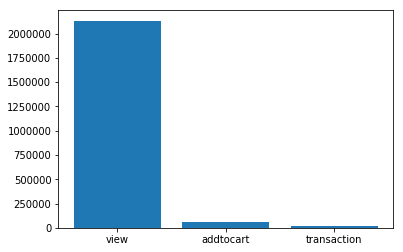

In [7]:
#количество типов событий
plt.bar(np.arange(events.event.value_counts().shape[0]), events.event.value_counts().values)
plt.xticks(np.arange(events.event.value_counts().shape[0]), events.event.value_counts().index)
plt.show()

In [8]:
#количество типов событий
events.event.value_counts()

view           2132032
addtocart        54985
transaction      17864
Name: event, dtype: int64

In [9]:
#сделаем агрегированый сет по timestamp 
#вычислим продолжительность взаимодействия для visitorid

In [10]:
%%time
timestamps =  events[['timestamp','visitorid']].groupby('visitorid').agg(['max','min','count','nunique'])

Wall time: 1.24 s


In [11]:
timestamps['len,min'] = (timestamps['timestamp']['max'] - timestamps['timestamp']['min'])/(1000*60)

In [12]:
#у большинства пользователей мало событий - [их нужно будет отфильтровать тк они не несут полезную информацию]
print("Кол-во пользователей:",timestamps.shape[0])
print("Кол-во сессий с одним событием:",timestamps.loc[timestamps['timestamp']['count'] == 1].shape[0])
print("\nКол-во сессий с более чем одним событием :",timestamps.loc[timestamps['timestamp']['count'] > 1].shape[0])

Кол-во пользователей: 1123767
Кол-во сессий с одним событием: 801886

Кол-во сессий с более чем одним событием : 321881


In [13]:
#у большинства пользователей короткие сессии - [их тоже нужно будет отфильтровать]
print("Кол-во пользователей:",timestamps.shape[0])
print("Кол-во  сессий 0-ой длительности:",timestamps.loc[timestamps['len,min'] == 0].shape[0])
print("\nКол-во не 0-ой длительности :",timestamps.loc[timestamps['len,min'] > 0].shape[0])

Кол-во пользователей: 1123767
Кол-во  сессий 0-ой длительности: 801922

Кол-во не 0-ой длительности : 321845


In [14]:
# максимальная длительность сессии
timestamps['len,min'].max()

153809.0466

In [15]:
timestamps['len,min'].min()

0.0

In [16]:
#"отрежем" сессии с 1-м событием
visitors = timestamps.loc[timestamps['timestamp']['count'] > 1]

### Анализ интервалов между событиями пользователя

In [17]:
##отсортируем по timestamp и visitorid

In [18]:
e = events.sort_values(['visitorid', 'timestamp'], ascending=[True, True])

In [19]:
e = e.reset_index(drop=True)

In [20]:
## вычислим интервал между событиями в минутах

In [21]:
e['delta'] = 0

In [22]:
%%time
a = np.zeros(e.shape[0])
user = 0
delta =  np.nan
for index, row in e.iterrows():
    if user != row['visitorid']:
        #delta = row['timestamp']
        a[index] = np.nan
    else:
        a[index] = (row['timestamp'] - delta)/(1000*60)
    delta = row['timestamp'] 
    user = row['visitorid']
    #print(index)

Wall time: 3min 53s


In [23]:
e.delta = a

In [24]:
e.head()

,index,timestamp,visitorid,event,itemid,transactionid,delta
0,2126598,1439487966444,1,view,72028,-1,NaN
1,2024720,1438969904567,2,view,325215,-1,NaN
2,2024760,1438970013790,2,view,325215,-1,1.820383
3,2024834,1438970212664,2,view,259884,-1,3.314567
4,2024945,1438970468920,2,view,216305,-1,4.270933


In [25]:
#средне и медиана delta
print(e.delta.mean(), e.delta.median())

2717.14070343 2.1271333333333335


In [26]:
#квантили распределения delta

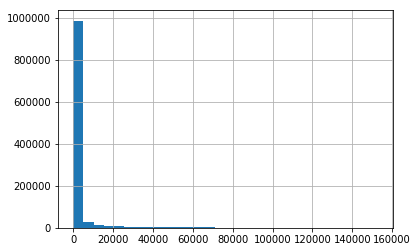

In [27]:
e.delta.hist(bins=30)

In [28]:
#количество сессий
e.shape[0]

2204881

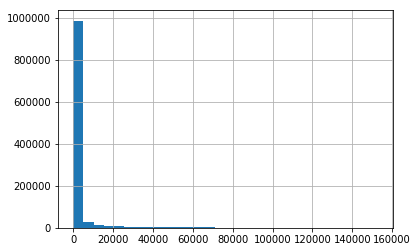

In [29]:
e.loc[e.visitorid.isin(visitors.index)].delta.hist(bins=30)

In [30]:
#отфильтруем сессии "отрезаных" пользователей
e.loc[e.visitorid.isin(visitors.index)].shape

(1402995, 7)

In [31]:
e_ = e.copy()

In [32]:
e = e.loc[e.visitorid.isin(visitors.index)]

In [33]:
e.shape

(1402995, 7)

In [34]:
#квантили распределения delta
e.delta.quantile([.25, .5, .75,])

0.25     0.601854
0.50     2.127133
0.75    31.553021
Name: delta, dtype: float64

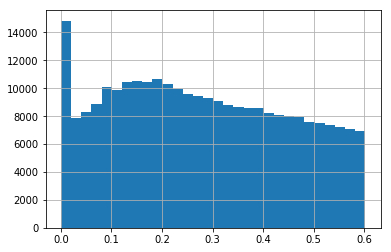

In [35]:
#1-й
e.loc[e.delta < e.delta.quantile(0.25)].delta.hist(bins=30)

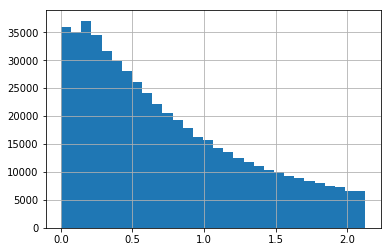

In [36]:
#2-ой
e.loc[e.delta < e.delta.quantile(0.5)].delta.hist(bins=30)

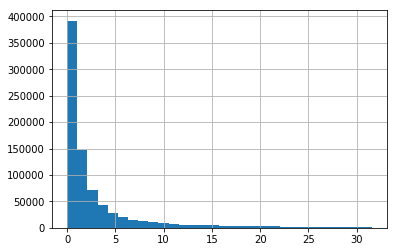

In [37]:
#3-й
e.loc[e.delta < e.delta.quantile(0.75)].delta.hist(bins=30)

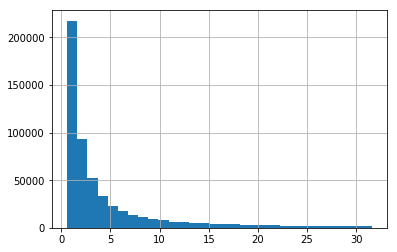

In [38]:
#дисперсия delta
e.loc[(e.delta < e.delta.quantile(0.75))&(e.delta > e.delta.quantile(0.25))].delta.hist(bins=30)

In [39]:
#для деления на сессии возьмем 3-й квантиль

In [40]:
e.loc[e.delta < e.delta.quantile(0.75)].shape

(810835, 7)

In [41]:
#Максимальная длинна интервала между событиями считающимися одной сессией в минутах
q = e.delta.quantile(0.75)
q

31.55302083333333

### разделим на сессии

In [42]:
e['delta1'] = 0
e['ssid'] = 0

In [43]:
e = e.reset_index(drop=True)

In [44]:
%%time
s = np.zeros(e.shape[0])
ssid = e.ssid.iloc[0]
d1 = np.zeros(e.shape[0])
for index, row in e.iterrows():
    if np.isnan(row['delta']):
        ssid +=1
        d1[index] = np.nan
    elif row['delta'] > q:
        d1[index] = np.nan
        ssid +=1
    else:
        d1[index] = row['delta']
    s[index] = ssid

Wall time: 2min 16s


In [45]:
e['ssid'] = s
e['delta1'] = d1

In [46]:
e.head(10)

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid
0,2024720,1438969904567,2,view,325215,-1,NaN,NaN,1.0
1,2024760,1438970013790,2,view,325215,-1,1.820383,1.820383,1.0
2,2024834,1438970212664,2,view,259884,-1,3.314567,3.314567,1.0
3,2024945,1438970468920,2,view,216305,-1,4.270933,4.270933,1.0
4,2025140,1438970905669,2,view,342816,-1,7.279150,7.279150,1.0
5,2025338,1438971444375,2,view,342816,-1,8.978433,8.978433,1.0
6,2025347,1438971463170,2,view,216305,-1,0.313250,0.313250,1.0
7,2025417,1438971657845,2,view,325215,-1,3.244583,3.244583,1.0
8,216860,1431581976753,7,view,139394,-1,NaN,NaN,2.0
9,216903,1431582162817,7,view,164941,-1,3.101067,3.101067,2.0


In [47]:
#количество уникальных  сессий 
e.ssid.unique().size

592160

In [48]:
#количество уникальных пользователей
e.visitorid.unique().size

321881

In [49]:
#средне и медиана delta
print(e.delta1.mean(), e.delta1.median())

3.13062773363 1.1186333333333334


### Анализ сессий по длительности

In [50]:
%%time
sessions =  e[['ssid','delta1']].groupby('ssid').agg(['mean','median','sum','count','nunique'])

Wall time: 696 ms


In [51]:
sessions_ = sessions.copy()

In [52]:
sessions.shape

(592160, 5)

In [53]:
sessions.loc[np.isnan(sessions['delta1']['sum'])].shape

(285387, 5)

In [54]:
print(sessions['delta1']['sum'].min(),sessions['delta1']['sum'].max(),sessions['delta1']['sum'].mean())

0.0 728.404133333 8.27459567302


In [55]:
#количество сессий 
sessions.shape[0] - sessions.loc[np.isnan(sessions['delta1']['sum'])].shape[0]

306773

In [56]:
sessions.loc[sessions['delta1']['sum'] >= 0].shape

(306773, 5)

In [57]:
sessions.head()

delta1                                   
          mean    median        sum count nunique
ssid                                             
1.0   4.174471  3.314567  29.221300     7       7
2.0   3.101067  3.101067   3.101067     1       1
3.0        NaN       NaN        NaN     0       0
4.0   0.883883  0.883883   0.883883     1       1
5.0   0.393533  0.393533   0.393533     1       1

In [58]:
sessions = sessions.loc[sessions['delta1']['sum'] >= 0]

In [59]:
#оставим только 99% сессий

In [60]:
sessions = sessions.loc[sessions['delta1']['sum'] < sessions['delta1']['sum'].quantile(0.99)]

In [61]:
sessions.shape[0]

303705

In [62]:
print(sessions['delta1']['sum'].min(),sessions['delta1']['sum'].max(),sessions['delta1']['sum'].mean())

0.0 62.4508833333 7.12909737964


In [63]:
#квантили
sessions['delta1']['sum'].quantile([.33, .66, .99])

0.33     1.352789
0.66     5.950815
0.99    45.638203
Name: sum, dtype: float64

In [64]:
sessions['delta1']['sum'].quantile([.25, .5, .75])

0.25    0.917700
0.50    2.906800
0.75    9.170033
Name: sum, dtype: float64

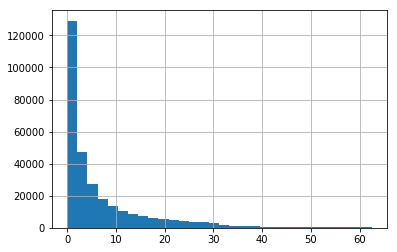

In [65]:
sessions['delta1']['sum'].hist(bins=30)

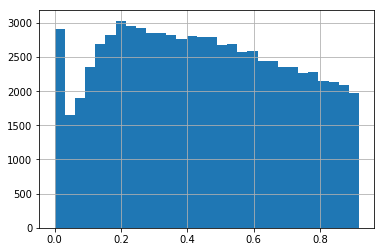

In [66]:
#1-й
sessions.loc[sessions['delta1']['sum'] <= sessions['delta1']['sum'].quantile(0.25)]['delta1']['sum'].hist(bins=30)

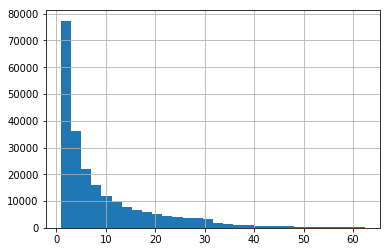

In [67]:
sessions.loc[sessions['delta1']['sum'] > sessions['delta1']['sum'].quantile(0.25)]['delta1']['sum'].hist(bins=30)

In [68]:
sessions.loc[sessions['delta1']['sum'] <= sessions['delta1']['sum'].quantile(0.25)].shape

(75928, 5)

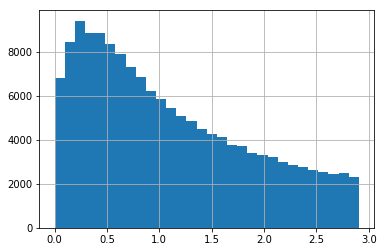

In [69]:
#2-й
sessions.loc[sessions['delta1']['sum'] <= sessions['delta1']['sum'].quantile(0.5)]['delta1']['sum'].hist(bins=30)

In [70]:
sessions.loc[sessions['delta1']['sum'] <= sessions['delta1']['sum'].quantile(0.5)].shape

(151853, 5)

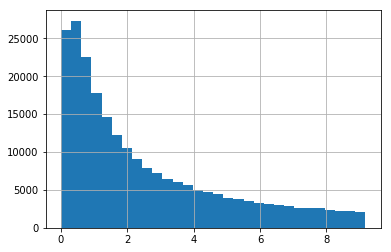

In [71]:
#3-й
sessions.loc[sessions['delta1']['sum'] <= sessions['delta1']['sum'].quantile(0.75)]['delta1']['sum'].hist(bins=30)

In [72]:
sessions.loc[sessions['delta1']['sum'] < sessions['delta1']['sum'].quantile(0.99)].shape

(300667, 5)

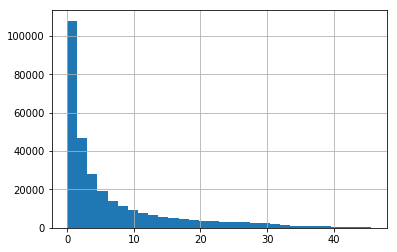

In [73]:
#99%
sessions.loc[sessions['delta1']['sum'] < sessions['delta1']['sum'].quantile(0.99)]['delta1']['sum'].hist(bins=30)

In [74]:
# разбелили все сессии на короткие средние длинные
short_sessions = sessions_.loc[sessions_['delta1']['sum'] <= sessions['delta1']['sum'].quantile(0.25)]
midle_sessions = sessions_.loc[(sessions_['delta1']['sum'] > sessions['delta1']['sum'].quantile(0.25))&(sessions['delta1']['sum'] <= sessions['delta1']['sum'].quantile(0.75))]
long_sessions = sessions_.loc[sessions_['delta1']['sum'] > sessions['delta1']['sum'].quantile(0.75)]

In [75]:
short_sessions.shape[0]

75928

In [76]:
print(short_sessions['delta1']['sum'].min(),short_sessions['delta1']['sum'].max(),short_sessions['delta1']['sum'].mean())

0.0 0.9177 0.444620626998


In [77]:
midle_sessions.shape[0]

151851

In [78]:
print(midle_sessions['delta1']['sum'].min(),midle_sessions['delta1']['sum'].max(),midle_sessions['delta1']['sum'].mean())

0.917716666667 9.17003333333 3.56351954745


In [79]:
long_sessions.shape[0]

78994

In [80]:
print(long_sessions['delta1']['sum'].min(),long_sessions['delta1']['sum'].max(),long_sessions['delta1']['sum'].mean())

9.17011666667 728.404133333 24.8568166776


In [81]:
e['session_type'] = np.nan

In [82]:
##сохраним данные для следующего анализа
e['session_type'].loc[e.ssid.isin(short_sessions.index)] = 0
e['session_type'].loc[e.ssid.isin(midle_sessions.index)] = 1
e['session_type'].loc[e.ssid.isin(long_sessions.index)] = 2

In [83]:
e.to_csv('./data/train_events_1.csv')

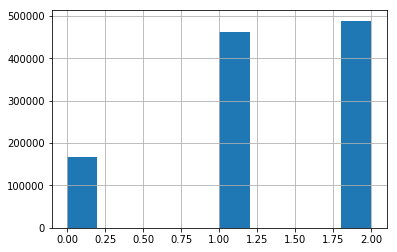

In [84]:
#распределение событий по типам сессий
e.session_type.hist(bins=10)

In [85]:
c = e.loc[np.isnan(e.session_type)]

In [86]:
c.ssid.unique().shape

(285387,)

In [87]:
c.head()

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,session_type
10,260894,1431750039214,7,view,226353,-1,2797.939950,NaN,3.0,NaN
15,724929,1433650323043,23,view,44608,-1,NaN,NaN,6.0,NaN
22,2028406,1438980041693,37,view,168952,-1,NaN,NaN,10.0,NaN
25,2041947,1439062713781,37,view,168952,-1,990.943783,NaN,12.0,NaN
29,2124376,1439481275366,37,view,168952,-1,2952.471050,NaN,14.0,NaN


In [88]:
c_ =  c[['ssid','event']].groupby('ssid').agg(['count'])

In [89]:
c_.loc[ c_['event']['count'] > 1].shape

(0, 1)

In [90]:
#session_type NaN только у тех у кого 1 событие в сесии. длинные и короткие не попавшие в 99% мы тоже разметили

In [91]:
# к коротким  у нас относятся 75928 сесисий при этом их длительность всего 0.917700 мин.

In [92]:
#посмотрим на них подробнее

In [93]:
short_sessions.head()

delta1                                  
          mean    median       sum count nunique
ssid                                            
4.0   0.883883  0.883883  0.883883     1       1
5.0   0.393533  0.393533  0.393533     1       1
20.0  0.703850  0.703850  0.703850     1       1
27.0  0.285994  0.102150  0.857983     3       3
28.0  0.857583  0.857583  0.857583     1       1

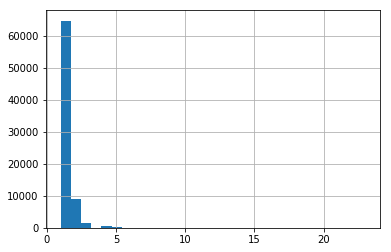

In [94]:
short_sessions['delta1']['count'].hist(bins = 30)

In [95]:
short_sessions.shape

(75928, 5)

In [96]:
short_sessions.loc[short_sessions['delta1']['count'] == 1].shape

(64690, 5)

In [97]:
short_sessions.loc[short_sessions['delta1']['count'] > 1].shape

(11238, 5)

In [98]:
short_sessions.loc[short_sessions['delta1']['count'] > 2].shape

(2386, 5)

In [99]:
short_sessions.loc[short_sessions['delta1']['count'] > 5].shape

(127, 5)

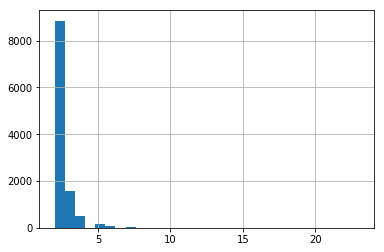

In [100]:
short_sessions.loc[short_sessions['delta1']['count'] > 1]['delta1']['count'].hist(bins=30)

In [101]:
short_events_ = e.loc[e.ssid.isin(short_sessions.index)]

In [102]:
#Количество событий в коротких сессиях:
short_events_.shape

(166861, 10)

In [103]:
#Количетво пользователей с короткими сессиями
short_events_.visitorid.unique().shape

(71326,)

In [104]:
#Обшие количетво пользователей
e.loc[e.session_type >= 0]['visitorid'].unique().shape

(253761,)

In [105]:
short_events = e.loc[e.visitorid.isin(short_events_.visitorid.unique())]

In [106]:
short_events.shape

(357129, 10)

In [107]:
#Сгруппируем данные события по пользователям у которых есть короткие сессии

In [108]:
%%time
s = short_events[['ssid','delta','session_type','visitorid','event']].groupby('visitorid').agg(['max','count','nunique','unique'])

Wall time: 37.2 s


In [109]:
s.head()

ssid                           delta                \
            max count nunique  unique       max count nunique   
visitorid                                                       
13          4.0     2       1   [4.0]  0.883883     1       1   
22          5.0     2       1   [5.0]  0.393533     1       1   
58         20.0     2       1  [20.0]  0.703850     1       1   
65         27.0     4       1  [27.0]  0.653917     3       3   
73         28.0     2       1  [28.0]  0.857583     1       1   

                                                          session_type        \
                                                   unique          max count   
visitorid                                                                      
13                                  [nan, 0.883883333333]          0.0     2   
22                                  [nan, 0.393533333333]          0.0     2   
58                                         [nan, 0.70385]          0.0     2   
65         [nan, 0.653916666667, 0.101916666667, 0.10215]          0.0     4   
73                                  [nan, 0.857583333333]          0.0     2   

                         event                        
          nunique unique   max count nunique  unique  
visitorid                                             
13              1  [0.0]  view     2       1  [view]  
22              1  [0.0]  view     2       1  [view]  
58              1  [0.0]  view     2       1  [view]  
65              1  [0.0]  view     4       1  [view]  
73              1  [0.0]  view     2       1  [view]

In [110]:
s.shape[0]

71326

In [111]:
#количество пользователей с 1 сессией
s.loc[s['ssid']['nunique'] == 1 ].shape

(51405, 16)

In [112]:
s['event']['unique'].value_counts()[:5]

[view]                            64797
[addtocart]                         194
[transaction]                         5
[view, addtocart, transaction]        1
[view, addtocart]                     1
Name: unique, dtype: int64

In [113]:
#количество пользователей с > 1 сессией
# потенциально неверно  размеченых сессий
s.loc[s['ssid']['nunique'] > 1 ].shape

(19921, 16)

In [114]:
#Сгруппируем события по данным пользователям и по сессиям.

In [115]:
s_ = s.loc[s['ssid']['nunique'] > 1 ]

In [116]:
v = e.loc[e.visitorid.isin(s_.index)]

In [117]:
v.shape

(245233, 10)

In [118]:
v.event = v.event.replace({'view': 0, 'addtocart': 1, 'transaction': 2})

In [119]:
%%time
v_s = v[['ssid','delta','session_type','visitorid','event']].groupby(['visitorid','ssid']).agg(['max','sum','count','nunique','unique'])

Wall time: 28.5 s


In [120]:
v_s.index.get_level_values('visitorid').unique().shape

(19921,)

In [121]:
#Количество сессий при данной группировке:
v_s.loc[ (v_s['session_type']['max'] == 0.0) | (np.isnan(v_s['delta']['sum']))  ].shape

(31696, 15)

In [122]:
# короткие начальные сессии 

In [123]:
#кол-во начальных сессий
v_s.loc[ ((v_s['session_type']['max'] == 0.0) & (v_s['delta']['sum'] <= 31.553021)) |(np.isnan(v_s['delta']['sum']))].shape

(15462, 15)

In [124]:
indx = v_s.loc[(np.isnan(v_s['session_type']['max'])) | ((v_s['session_type']['max'] == 0.0) & (v_s['delta']['sum'] <= 31.553021) )].index.get_level_values('visitorid')

In [125]:
indx.unique().shape

(17731,)

In [126]:
v_s_s = v_s.loc[v_s.index.get_level_values('visitorid').isin(indx)]

In [127]:
v_s_s.index.get_level_values('visitorid').unique().shape

(17731,)

In [128]:
#найдем все сесии за начальными

In [129]:
%%time
r = []
i = 0
k = 0
for index  , row in v_s_s.iterrows():
    if index[0]  == i:
        if k < 1:        
            r.append(index[1])
            
        k = k +1
    else:
        #r.append(index[1])
        i  = index[0]
        k = 0

Wall time: 5.31 s


In [130]:
v_s_s_ = v_s_s.loc[v_s_s.index.get_level_values('ssid').isin(r)]

In [131]:
v_s_s_['delta']['max'].quantile([.25, .5, .75])

0.25      282.354692
0.50     2548.097817
0.75    14454.016517
Name: max, dtype: float64

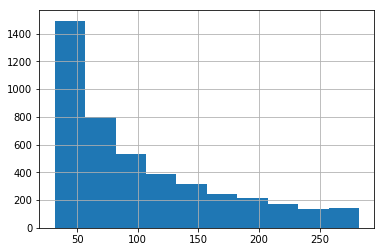

In [132]:
v_s_s_.loc[v_s_s_['delta']['max'] <=282.354692]['delta']['max'].hist()

In [133]:
#Ошибочные начальные сессии
v_s_s_.loc[v_s_s_['delta']['max'] <= 62.45]['delta']['max'].shape[0]

1743

In [134]:
# конечные короткие  сессии 

In [135]:
v_s.loc[ (v_s['session_type']['max'] == 0.0) & (v_s['delta']['max'] > 31.553021)].shape

(16234, 15)

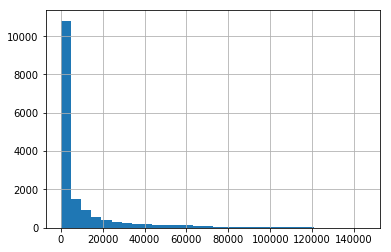

In [136]:
v_s.loc[ (v_s['session_type']['max'] == 0.0) & (v_s['delta']['max'] > 31.553021)]['delta']['max'].hist(bins = 30)

In [137]:
v_s.loc[ (v_s['session_type']['max'] == 0.0) & (v_s['delta']['max'] > 31.553021)]['delta']['sum'].quantile([.25, .5, .75])

0.25     235.986304
0.50    1455.881458
0.75    8962.787833
Name: sum, dtype: float64

In [138]:
t = v_s.loc[ (v_s['session_type']['max'] == 0.0) & (v_s['delta']['sum'] > 31.553021)]

In [139]:
t.index.get_level_values('visitorid').unique().shape

(12785,)

In [140]:
t_ = t.loc[(t['delta']['sum'] <= 62.45)]

In [141]:
#Количество ошибочных оконечных сессий 
t_.shape[0]

1631

In [142]:
#Кол-во ошибочно размеченные сессии
v_s_s_.loc[v_s_s_['delta']['max'] <= 62.45]['delta']['max'].shape[0] + t_.shape[0]

3374